In [1]:
%load_ext autotime

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('talk')

time: 9.25 ms


# Load data and generate features

In [14]:
def load_data():
    date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
    return pd.read_csv('../data/raw/AirPassengers.csv', index_col='Month',
                       parse_dates=['Month'], date_parser=date_parser)['#Passengers']\
             .sort_index()

def remove_trend_and_seasonality(ts):
    ts_log = np.log(ts)
    return ts_log - ts_log.shift()

def generate_autoregression_features(ts, p, col='x_t'):
    X = pd.concat([ts[col].shift(-n).rename('x_t-{}'.format(n)) for n in range(1, p+1)], axis=1)
    return pd.merge(ts, X, how='left', left_index=True, right_index=True)

def generate_movingaverage_features(ts, q, col='x_t'):
    er = ts[col] - ts[col].mean()
    X = pd.concat([er.shift(-n).rename('er_t-{}'.format(n)) for n in range(1, q+1)], axis=1)
    return pd.merge(ts, X, how='left', left_index=True, right_index=True)


data = load_data()
data = remove_trend_and_seasonality(data)
data = data.rename('x_t').to_frame()
data = generate_autoregression_features(data, 2)
data = generate_movingaverage_features(data, 2)

time: 8.11 ms


In [17]:
data.head()

,x_t,x_t-1,x_t-2,er_t-1,er_t-2
Month,,,,,
1949-01-01,NaN,0.052186,0.112117,0.042746,0.102677
1949-02-01,0.052186,0.112117,-0.022990,0.102677,-0.032430
1949-03-01,0.112117,-0.022990,-0.064022,-0.032430,-0.073462
1949-04-01,-0.022990,-0.064022,0.109484,-0.073462,0.100044
1949-05-01,-0.064022,0.109484,0.091937,0.100044,0.082497


time: 10.2 ms


# ARIMA from statsmodels

In [91]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

time: 3.12 ms


/home/felipe/.miniconda3/envs/time-series/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/felipe/.miniconda3/envs/time-series/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/felipe/.miniconda3/envs/time-series/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/felipe/.miniconda3/envs/time-series/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecate

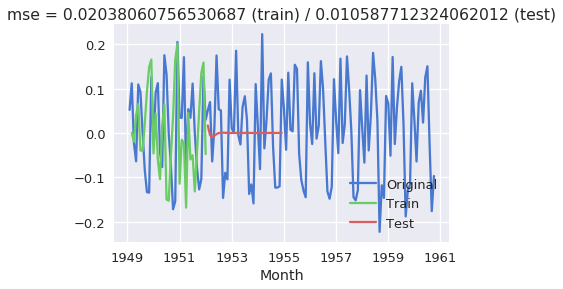

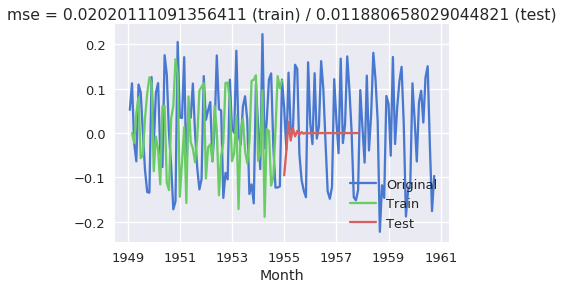

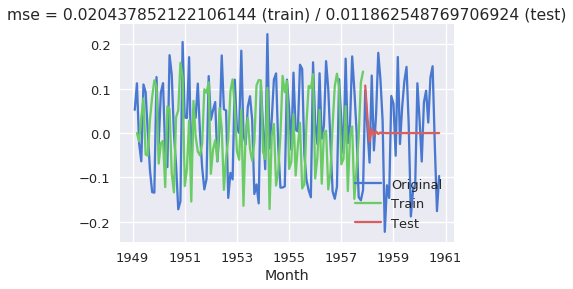

time: 1.62 s


In [118]:
tscv = TimeSeriesSplit().split(X)
for train_index, test_index in tscv:
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = ARIMA(y_train, (2, 1, 2))
    model = model.fit()
    y_pred_train = model.fittedvalues
    mse_train = ((y_train - y_pred_train)**2).mean()
    y_pred = model.predict(start=y_test.index.min(), end=y_test.index.max())
    mse_test = ((y_test - y_pred)**2).mean()

    fig, ax = plt.subplots()
    y.plot(ax=ax, label='Original')
    y_pred_train.plot(ax=ax, label='Train')
    y_pred.plot(ax=ax, label='Test')
    plt.legend(loc='best')
    plt.title('mse = {} (train) / {} (test)'.format(mse_train, mse_test))

# Custom scikit-learn studies
> **TODO**: my forecasts are based on features built from the target ($y_t$) instead of the future predicionts ($\hat{y}_t$). While this *may* be ok for short-term forecasts, it surely is not for long-term predictions.

In [73]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics.regression import r2_score, mean_squared_error

time: 2.9 ms


In [69]:
def train_and_eval_model(X, y, model):
    tscv = TimeSeriesSplit().split(X)
    for train_index, test_index in tscv:
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        model.fit(X_train, y_train)    
        y_pred_train = pd.Series(data=model.predict(X_train), index=X_train.index)
        mse_train = mean_squared_error(y_train, y_pred_train)
        y_pred = pd.Series(data=model.predict(X_test), index=X_test.index)
        mse_test = mean_squared_error(y_test, y_pred)

        fig, ax = plt.subplots()
        y.plot(ax=ax, label='Original')
        y_pred_train.plot(ax=ax, label='Train')
        y_pred.plot(ax=ax, label='Test')
        plt.legend(loc='best')
        plt.title('mse = {} (train) / {} (test)'.format(mse_train, mse_test))

time: 4.11 ms


In [40]:
X = data.dropna().drop('x_t', axis=1)
y = data.dropna()['x_t']

time: 11.1 ms


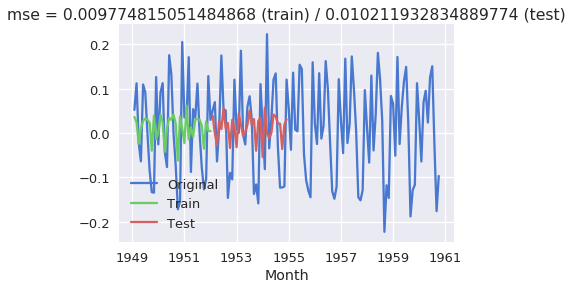

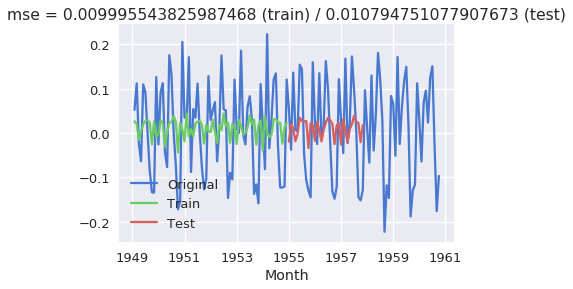

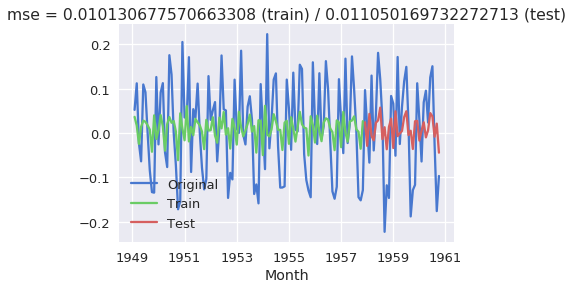

time: 614 ms


In [70]:
train_and_eval_model(X, y, LinearRegression())

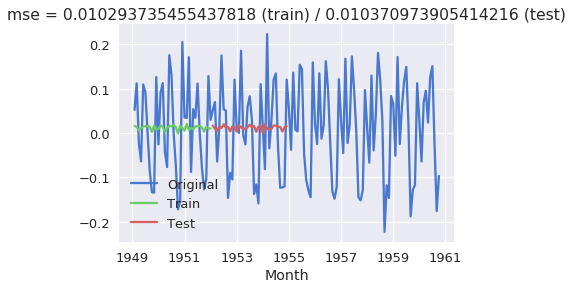

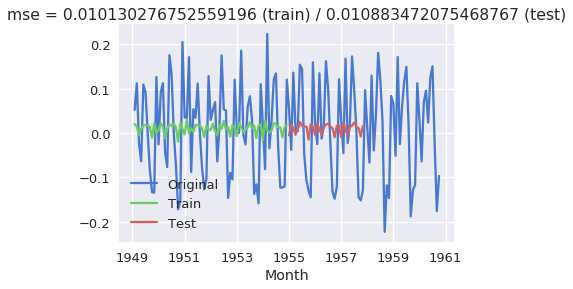

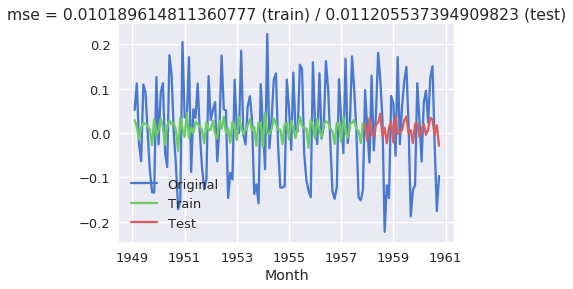

time: 673 ms


In [71]:
train_and_eval_model(X, y, BayesianRidge())

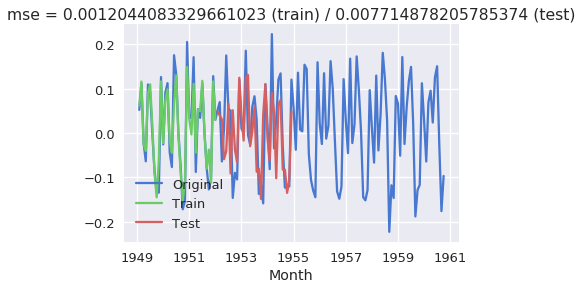

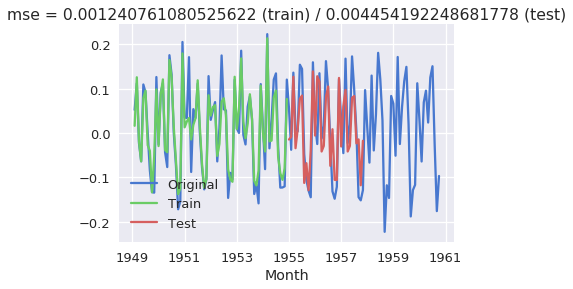

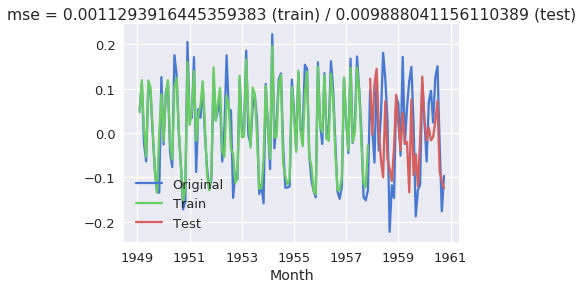

time: 629 ms


In [72]:
train_and_eval_model(X, y, RandomForestRegressor())

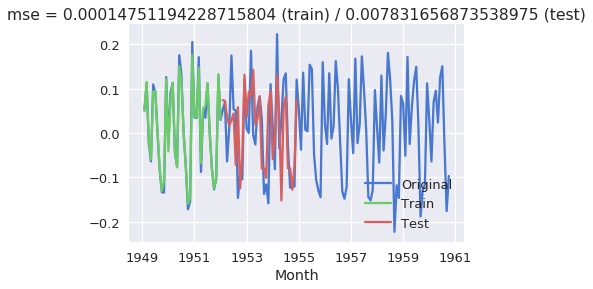

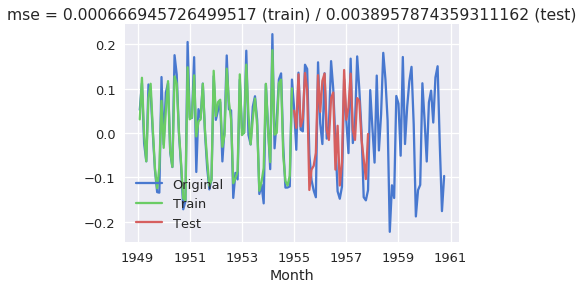

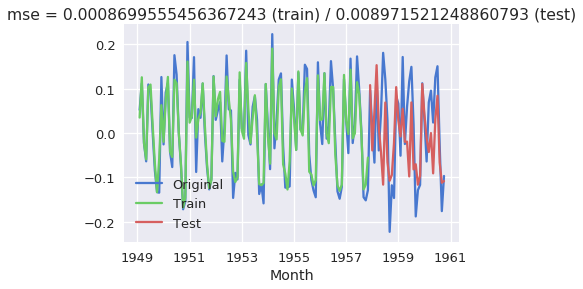

time: 634 ms


In [74]:
train_and_eval_model(X, y, XGBRegressor())

# TODO: run-or-walk kaggle dataset

In [53]:
def date_parser(d):
    return pd.datetime.strptime(d, '%Y-%m-%d')

data = pd.read_csv('/home/felipe/.kaggle/datasets/vmalyi/run-or-walk/dataset.csv',
                   parse_dates=['date'], date_parser=date_parser)

time: 897 ms


In [54]:
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S:%f').apply(lambda x: x.time())

time: 521 ms


In [63]:
data.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-06-30,13:51:15.847724,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-06-30,13:51:16.246945,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-06-30,13:51:16.446233,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-06-30,13:51:16.646117,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-06-30,13:51:16.846738,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


time: 29 ms


In [64]:
data.username.value_counts()

viktor    88588
Name: username, dtype: int64

time: 28.8 ms


In [6]:
data.wrist.value_counts()

1    46258
0    42330
Name: wrist, dtype: int64

time: 4.85 ms


In [8]:
data.activity.value_counts()

1    44365
0    44223
Name: activity, dtype: int64

time: 12.1 ms
